In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

year = 2016

# Car specifications
car_efficiency = 191 / 1000  # kWh per km
battery_capacity = 72  # kWh
battery_min = 10  # %
battery_max = 80  # %
min_battery_level = battery_min / 100 * battery_capacity  # kWh
max_battery_level = battery_max / 100 * battery_capacity  # kWh

# Driver profiles
distance_to_work = 22  # km one way
other_trips_avg = 12  # km

# Load PV and BS data
pv_bs_profile = pd.read_csv('C:\\Users\\DianaEspinosaLozano\\anaconda3\\envs\\thesis\\GETTINGSTARTED\\df_pv_bs_240906.csv')

# Assume that the data is for the year 2016
hours_per_year = 8784

results = pd.DataFrame(index=np.arange(hours_per_year), columns=['EV_battery', 'EV_at_home', 'PV_used', 'Grid_used', 'BS_used'])

In [4]:
# Function to generate car availability (home or not) based on the driver profile
def generate_car_availability(homeoffice=True):
    availability = np.ones(hours_per_year)  # Car is at home initially
    weekdays = np.arange(7, hours_per_year, 24)  # Each day starts at 7 am (weekday)
    
    for i in range(0, hours_per_year, 24):  # Loop through each day
        day_of_week = i // 24 % 7
        
        if homeoffice and day_of_week in [1, 3, 5]:  # Mon, Wed, Fri (work from home)
            continue
        elif not homeoffice and day_of_week in range(5):  # Mon-Fri for no homeoffice
            availability[i+7:i+16] = 0  # Not at home from 7 am to 4 pm (commuting to work)
        
        # Random weekend trips
        if day_of_week in [6, 0]:  # Saturday, Sunday
            if np.random.rand() < 0.5:  # Randomly decide if there's a trip
                trip_duration = np.random.randint(2, 8)  # Random duration of trip
                start_hour = np.random.randint(7, 14)  # Random trip starting time
                availability[i+start_hour:i+start_hour+trip_duration] = 0

    return availability

In [5]:
# Simulate the EV charging and driving behavior for each hour
car_availability = 0.0
def simulate_ev_charging(homeoffice=True):
    # Generate car availability profile
    car_availability = generate_car_availability(homeoffice)
    
    # Initial conditions
    ev_battery = max_battery_level
    bs_soc = pv_bs_profile['battery_soc'].iloc[0]  # Start with the initial battery storage state
    
    max_charge_power = 11  # kW

    for hour in range(hours_per_year):
        pv_used_total = 0
        grid_used_total = 0
        bs_used_total = 0
        # Driving consumption logic (for commuting or other trips)
        if car_availability[hour] == 0:  # If car is not at home (driving)
            # Check if driving to work or other random trips
            if hour % 24 == 7:  # Leaving for work at 7 am
                trip_distance = distance_to_work * 2  # To and from work
            else:
                trip_distance = np.random.choice([0, other_trips_avg])
            
            # Deduct battery consumption for driving
            ev_battery -= trip_distance * car_efficiency
            ev_battery = max(ev_battery, min_battery_level)  # Can't go below min battery level
            
        # Charging logic (if car is at home)
        if car_availability[hour] == 1 and ev_battery < max_battery_level:
            # Check PV surplus and BS state
            pv_surplus = pv_bs_profile['pv_excess'].iloc[hour]
            bs_soc = pv_bs_profile['battery_soc'].iloc[hour]
            pv = pv_bs_profile['pv'].iloc[hour]
            
            # Check the decision flow for charging (based on the chart)
            if ev_battery < max_battery_level:  # EV battery not full
                charge_power = min(max_charge_power, max_battery_level - ev_battery)  # Cap at max charging power

                if pv_surplus >= 1.4:  # Sufficient PV surplus to charge only from PV
                    charge_power = min(pv_surplus, charge_power)
                    ev_battery += charge_power
                    pv_used_total += charge_power
                
                elif 0.9 < pv_surplus < 1.4:  # Partial PV + grid charging
                    grid_contribution = 1.4 - pv_surplus  # Amount taken from the grid to reach 1.4 kW
                    charge_power = min(1.4, charge_power)  # Ensure at least 1.4 kW total
                    ev_battery += charge_power
                    pv_used_total += pv_surplus
                    grid_used_total += grid_contribution
                
                elif pv<10 and bs_soc > 1.4:  # Use battery storage if above 10%
                    bs_available_power = max(0, 10 - pv)
                    charge_power = min(bs_available_power, charge_power)
                    ev_battery += charge_power
                    bs_used_total += charge_power

                    # Actualize the BS state of charge
                    bs_soc -= charge_power
                    bs_soc = max(bs_soc, 10)  # BS can't go below 10%
                    pv_bs_profile['battery_soc'].iloc[hour] = bs_soc  # Update BS SOC in the profile
                
                elif ev_battery > min_battery_level and ev_battery <= 20:  # Charge from grid if very low
                    charge_power = min(1.4, charge_power)
                    ev_battery += charge_power
                    grid_used_total += charge_power
        
        # Update results
        results.loc[hour, 'EV_battery'] = ev_battery
        results.loc[hour, 'EV_at_home'] = car_availability[hour]
        results.loc[hour, 'PV_used'] = pv_used_total
        results.loc[hour, 'Grid_used'] = grid_used_total
        results.loc[hour, 'BS_used'] = bs_used_total

    return results

In [6]:
# Simulate for both driver profiles (homeoffice and no homeoffice)
results_homeoffice = simulate_ev_charging(homeoffice=True)
results_no_homeoffice = simulate_ev_charging(homeoffice=False)

C:\Users\DianaEspinosaLozano\AppData\Local\Temp\ipykernel_6720\1781763767.py:61: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pv_bs_profile['battery_soc'].iloc[hour] = bs_soc  # Update BS SOC in the profile
C:\Users\DianaEspinosaLozano\AppD

In [7]:
results_homeoffice

,EV_battery,EV_at_home,PV_used,Grid_used,BS_used
0,57.6,1.0,0,0,0
1,57.6,1.0,0,0,0
2,57.6,1.0,0,0,0
3,57.6,1.0,0,0,0
4,57.6,1.0,0,0,0
...,...,...,...,...,...
8779,40.028,1.0,0,0,0
8780,40.028,1.0,0,0,0
8781,40.028,1.0,0,0,0
8782,40.028,1.0,0,0,0


In [8]:
results_no_homeoffice

,EV_battery,EV_at_home,PV_used,Grid_used,BS_used
0,57.6,1.0,0,0,0
1,57.6,1.0,0,0,0
2,57.6,1.0,0,0,0
3,57.6,1.0,0,0,0
4,57.6,1.0,0,0,0
...,...,...,...,...,...
8779,40.028,1.0,0,0,0
8780,40.028,1.0,0,0,0
8781,40.028,1.0,0,0,0
8782,40.028,1.0,0,0,0


In [9]:
results_homeoffice.set_index(pd.date_range(datetime.datetime(year, 1, 1, 0), periods= len(results_homeoffice), freq="h"), inplace=True)

In [10]:
results_homeoffice

,EV_battery,EV_at_home,PV_used,Grid_used,BS_used
2016-01-01 00:00:00,57.6,1.0,0,0,0
2016-01-01 01:00:00,57.6,1.0,0,0,0
2016-01-01 02:00:00,57.6,1.0,0,0,0
2016-01-01 03:00:00,57.6,1.0,0,0,0
2016-01-01 04:00:00,57.6,1.0,0,0,0
...,...,...,...,...,...
2016-12-31 19:00:00,40.028,1.0,0,0,0
2016-12-31 20:00:00,40.028,1.0,0,0,0
2016-12-31 21:00:00,40.028,1.0,0,0,0
2016-12-31 22:00:00,40.028,1.0,0,0,0


<function matplotlib.pyplot.show(close=None, block=None)>

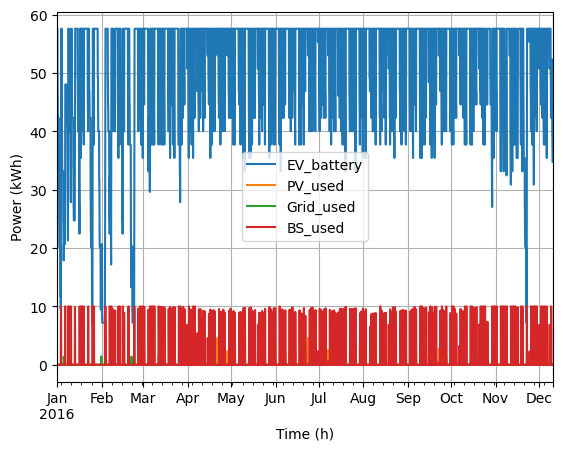

In [18]:
tag = results_homeoffice.loc['2016-01-01 00:00:00':'2016-12-10 23:00:00', ['EV_battery', 'PV_used', 'Grid_used', 'BS_used']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Power (kWh)')
plt.grid(True)
plt.show

In [12]:
# Summe
pv_used = round(sum(results_homeoffice['PV_used']))
grid_used = round(sum(results_homeoffice['Grid_used']))
bs_used = round(sum(results_homeoffice['BS_used']))

print('Homeoffice: \nPV used to charge EV: ', pv_used)
print('Grid used to charge EV: ', grid_used)
print('BS used to charge EV: ', bs_used)


Homeoffice: 
PV used to charge EV:  302
Grid used to charge EV:  39
BS used to charge EV:  4422


<function matplotlib.pyplot.show(close=None, block=None)>

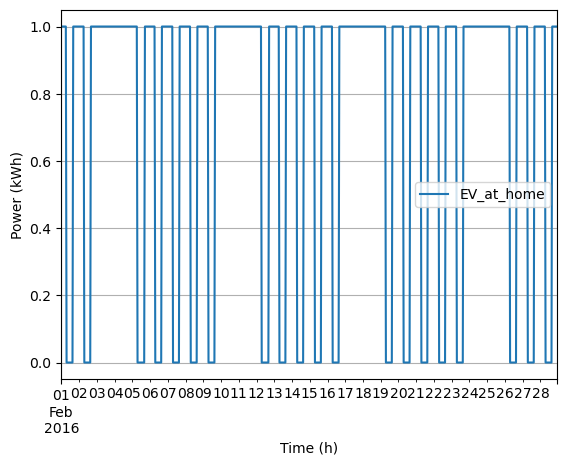

In [13]:
tag = results_homeoffice.loc['2016-02-01 00:00:00':'2016-02-28 23:00:00', ['EV_at_home']]
tag_plot = tag.plot()
tag_plot.set_xlabel('Time (h)')
tag_plot.set_ylabel('Power (kWh)')
plt.grid(True)
plt.show

In [14]:
from workalendar.europe import Germany
# Get holidays
year = 2016
cal = Germany()
holidays = dict(cal.holidays(year))
holidays

{datetime.date(2016, 1, 1): 'New year',
 datetime.date(2016, 3, 25): 'Good Friday',
 datetime.date(2016, 3, 28): 'Easter Monday',
 datetime.date(2016, 5, 1): 'Labour Day',
 datetime.date(2016, 5, 5): 'Ascension Thursday',
 datetime.date(2016, 5, 16): 'Whit Monday',
 datetime.date(2016, 10, 3): 'Day of German Unity',
 datetime.date(2016, 12, 25): 'Christmas Day',
 datetime.date(2016, 12, 26): 'Second Christmas Day'}

In [ ]:
# Turn results EV into SOC